In [1]:
import os
import sys

parent_dir = os.path.dirname('/home/jupyter/')
sys.path.append(parent_dir)

import warnings
warnings.filterwarnings("ignore")

import time
import numpy as np
import pandas as pd
import scanpy as sc

import torch
import torch.nn.functional as F
torch.manual_seed(0)

from multivib.multiVIB import multivib, multivibLoRA
from multivib.multiVIB import multivib_vertical_training

from multivib.multiVIB import scale_by_batch

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

# Prepare data for model training

This tutorial uses 10X Multiome PBMC data to demonstrate multiVIB alleviates the problem of spurious alignment in vertical integration. Correspondence of 3 cell types between RNA and ATAC modality are hold out in the training, and we visualize their alignment after integration. 

In [2]:
adata_rna = sc.read_h5ad('../data/PBMC/multiome_gex_processed_training.h5ad')
adata_rna.obs['source']='RNA-seq'
# sc.pp.normalize_total(adata_rna, target_sum=1e4)
# sc.pp.log1p(adata_rna)

adata_dna = sc.read_h5ad('../data/PBMC/multiome_atac_processed_training.h5ad')
adata_dna.obs['source']='ATAC-seq'
sc.pp.normalize_total(adata_dna, target_sum=1e4)
sc.pp.log1p(adata_dna)

In [3]:
# get highly variable features for both modalities
sc.pp.highly_variable_genes(adata_rna, n_top_genes=3000, flavor='seurat_v3', subset=True)
sc.pp.highly_variable_genes(adata_dna, n_top_genes=5000, flavor='seurat_v3', subset=True)

In [4]:
# majority of cells in this Multiome data will be used as anchors
# to learn correspondence between RNA and ATAC modality.
adata_rna.obs['use'] = 'reference'
adata_dna.obs['use'] = 'reference'

In [5]:
# We hold 3 cell types for alignment evaluation
hold_out_ct = ['CD16+ Mono', 'CD8+ T', 'B1 B']
hold_out_idx = np.isin(adata_rna.obs['cell_type'], hold_out_ct)

# the correspondence of these 3 holdout cell types are not known during training
adata_rna.obs['use'][hold_out_idx] = 'query'
adata_dna.obs['use'][hold_out_idx] = 'query'

In [6]:
# encode batch/modality covariates via one-hot encoding
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(np.expand_dims(
    adata_rna.obs['source'].values.tolist()+adata_dna.obs['source'].values.tolist(),
    axis=1))
rna_batch = enc.transform(np.expand_dims(adata_rna.obs['source'], 1))
dna_batch = enc.transform(np.expand_dims(adata_dna.obs['source'], 1))

rna_batch = np.asarray(rna_batch.todense())
dna_batch = np.asarray(dna_batch.todense())

rna_batch_paired = rna_batch[adata_rna.obs['use']=='reference',:]
dna_batch_paired = dna_batch[adata_dna.obs['use']=='reference',:]

In [7]:
print(rna_batch.shape)
print(dna_batch.shape)

(20952, 2)
(20952, 2)


In [8]:
# Scale data for training
X_rna = np.asarray(adata_rna.X.todense())
X_dna = np.asarray(adata_dna.X.todense())

X_rna = scale_by_batch(X_rna, adata_rna.obs['source'].values)
X_rna_paired = X_rna[adata_rna.obs['use']=='reference',:]

X_dna = scale_by_batch(X_dna, adata_dna.obs['source'].values)
X_dna_paired = X_dna[adata_dna.obs['use']=='reference',:]

# Set up multiVIB model for training

Feature dimension of A/B modality needs to be given while setting up model. We always consider RNA-seq data as modality A. All other modalities as B will be translated into A.

For the function of model training, inputs are structure as:
1. model;
2. scaled input matrices in the order of 1) all A modality, 2) all B modality, 3) paired A modality, and 4) paired B modality;
3. batch/modality covariates as the same order as input matrices;
4. traning related hyperparamters.

In [9]:
integrater = multivibLoRA(n_input_a=X_rna.shape[1],
                          n_input_b=X_dna.shape[1],
                          n_hidden=128, n_latent=20, n_batch=2)

In [10]:
start_time = time.time()
loss_history = multivib_vertical_training(integrater,
                                          X_rna, X_dna, X_rna_paired, X_dna_paired,
                                          rna_batch, dna_batch, rna_batch_paired, dna_batch_paired,
                                          epoch=200, temp=0.15, alpha=0.05, batch_size=256)

print("--- %s minutes ---" % int((time.time() - start_time)/60))

--- 20 minutes ---


# Visualization of alignment

We next visualize the alignment of these 3 holdout cell types.

In [11]:
# get unified cell embedding
integrater.to(torch.device("cpu"))
integrater.eval()

X_tensor_A=torch.tensor(X_rna).float()
X_tensor_B=torch.tensor(X_dna).float()

_, z_a=integrater.encoder(X_tensor_A)

z_btoa =integrater.translator(X_tensor_B)
_, z_b =integrater.encoder(z_btoa)

z_a = torch.Tensor.cpu(z_a).detach().numpy()
z_b = torch.Tensor.cpu(z_b).detach().numpy()

In [12]:
adata = adata_rna.concatenate(adata_dna)
adata.obsm['X_multivib'] = np.concatenate((z_a, z_b),0)

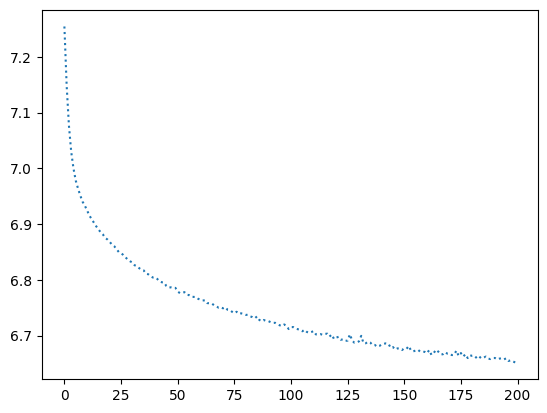

In [13]:
plt.plot(loss_history, linestyle = 'dotted')
plt.show()

In [14]:
sc.pp.neighbors(adata, use_rep='X_multivib', n_neighbors=15, metric='correlation', method='umap')
sc.tl.umap(adata,min_dist=0.15)

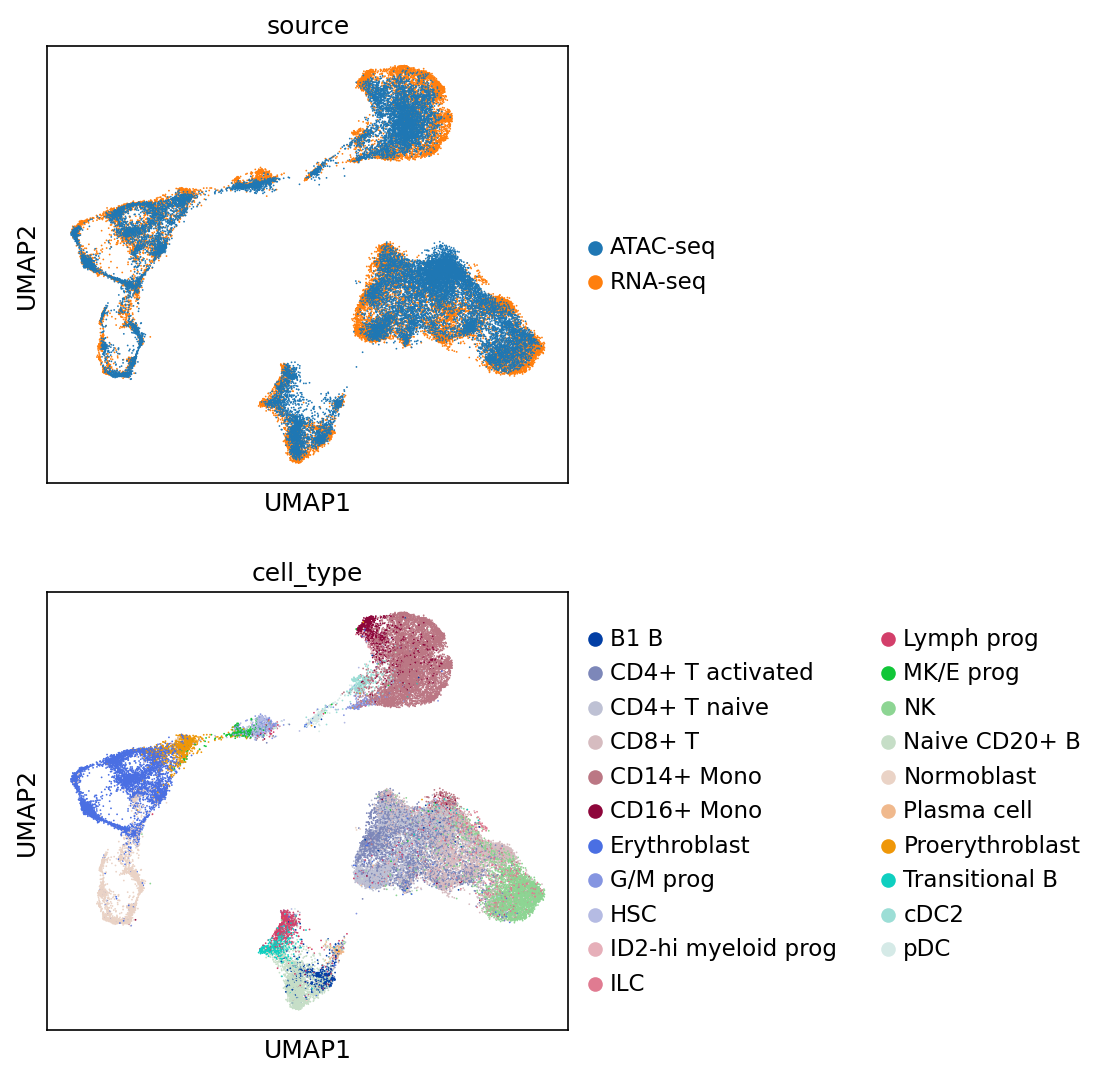

In [15]:
# Visualization of integration outcome
sc.set_figure_params(scanpy=True, dpi=75, dpi_save=75, fontsize=12, vector_friendly=True)
sc.pl.umap(adata, color=['source','cell_type'], ncols=1)

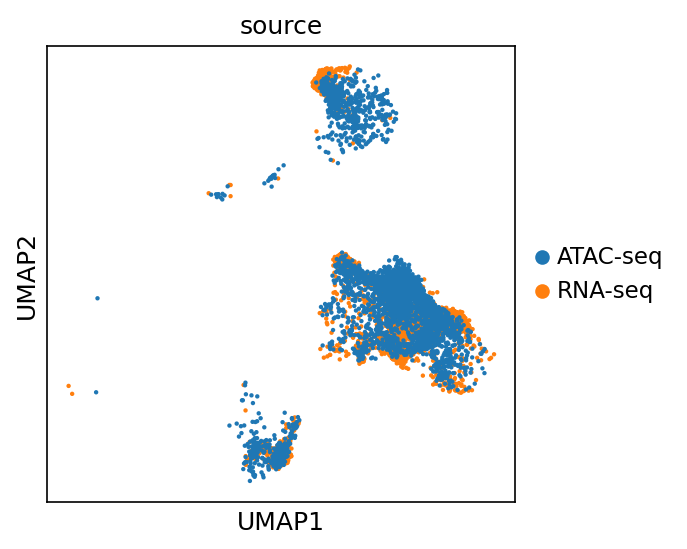

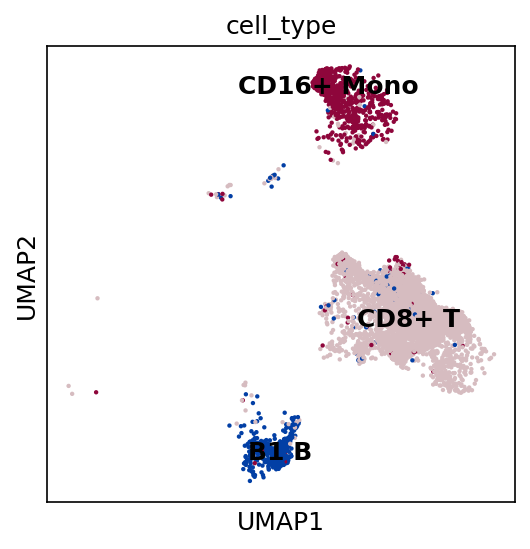

In [16]:
# Visualization of alignment of 3 holdout cell types
hold_out_ct = ['CD16+ Mono', 'CD8+ T', 'B1 B']
hold_out_idx = np.isin(adata.obs['cell_type'], hold_out_ct)

sc.pl.umap(adata[hold_out_idx], color=['source'], ncols=1)
sc.pl.umap(adata[hold_out_idx], color=['cell_type'], 
           legend_loc='on data', ncols=1)